In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, cohen_kappa_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = "../data/weatherAUS.csv"
df = pd.read_csv(data, header=0)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Les variables

In [4]:
# on parse la variable date en format datetime et on crée 3 variables
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
# on supprime Date
df.drop('Date', axis=1, inplace = True)

In [5]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)

In [6]:
print(df['RainToday'].value_counts())
print()
print(df['RainTomorrow'].value_counts())

RainToday
0.0    110319
1.0     31880
Name: count, dtype: int64

RainTomorrow
0.0    110316
1.0     31877
Name: count, dtype: int64


<Axes: xlabel='RainTomorrow', ylabel='count'>

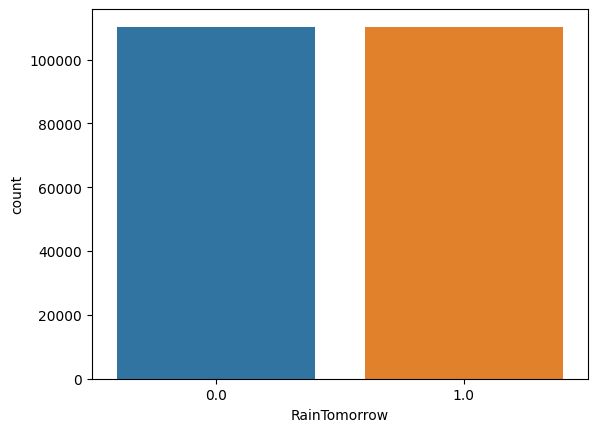

In [7]:
from sklearn.utils import resample

yes = df[df['RainTomorrow'] == 1]
no = df[df['RainTomorrow'] == 0]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

sns.countplot(oversampled, x='RainTomorrow')

In [8]:
df = pd.DataFrame(oversampled)

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 220632 entries, 0 to 27220
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       220632 non-null  object 
 1   MinTemp        219550 non-null  float64
 2   MaxTemp        220161 non-null  float64
 3   Rainfall       217508 non-null  float64
 4   Evaporation    125221 non-null  float64
 5   Sunshine       115801 non-null  float64
 6   WindGustDir    205141 non-null  object 
 7   WindGustSpeed  205278 non-null  float64
 8   WindDir9am     205904 non-null  object 
 9   WindDir3pm     214192 non-null  object 
 10  WindSpeed9am   218426 non-null  float64
 11  WindSpeed3pm   216279 non-null  float64
 12  Humidity9am    217461 non-null  float64
 13  Humidity3pm    214601 non-null  float64
 14  Pressure9am    198904 non-null  float64
 15  Pressure3pm    198886 non-null  float64
 16  Cloud9am       139293 non-null  float64
 17  Cloud3pm       135018 non-null  flo

In [10]:
# variables catégorielles
categorical = [var for var in df.columns if df[var].dtype=='O']
print('Il y a {} variables catégorielles :\n'.format(len(categorical)), categorical)

Il y a 4 variables catégorielles :
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [11]:
# valeurs manquantes
df[categorical].isnull().sum()

Location           0
WindGustDir    15491
WindDir9am     14728
WindDir3pm      6440
dtype: int64

In [12]:
# remplacement des valeurs manquantes par le Mode
df['WindGustDir'] = df['WindGustDir'].fillna(df['WindGustDir'].mode()[0])
df['WindDir9am'] = df['WindDir9am'].fillna(df['WindDir9am'].mode()[0])
df['WindDir3pm'] = df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0])

In [13]:
# valeurs manquantes
df[categorical].isnull().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

In [14]:
# variables numériques
numerical = [var for var in df.columns if df[var].dtype!='O']
print('Il y a {} variables numériques:\n'.format(len(numerical)),numerical)

Il y a 21 variables numériques:
 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month', 'Day']


In [15]:
# valeurs manquantes pour les variables numériques
(df[numerical].isna().sum().sort_values(ascending = False)) / len(df)

Sunshine         0.475140
Evaporation      0.432444
Cloud3pm         0.388040
Cloud9am         0.368664
Pressure3pm      0.098562
Pressure9am      0.098481
WindGustSpeed    0.069591
Humidity3pm      0.027335
Temp3pm          0.020659
WindSpeed3pm     0.019730
Humidity9am      0.014372
Rainfall         0.014159
RainToday        0.014159
WindSpeed9am     0.009999
Temp9am          0.007492
MinTemp          0.004904
MaxTemp          0.002135
RainTomorrow     0.000000
Year             0.000000
Month            0.000000
Day              0.000000
dtype: float64

In [16]:
df2 = pd.DataFrame(columns=df.columns)

for ville in df['Location'].unique():
    df_ville = pd.DataFrame(df[df['Location'] == ville])
   
    ## pour les valeurs nulles restantes, on remplace par la médiane
    df_ville[numerical] = df_ville[numerical].fillna(df_ville[numerical].median())

    ## si la médiane est nulle, on remplace par 0
    df_ville[numerical] = df_ville[numerical].fillna(0)
    
    df_ville = df_ville.reset_index(drop=True)
    df2 = pd.concat([df2, df_ville])

df2.head()
df = pd.DataFrame(df2)

In [17]:
# Remplacement des outliers
outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed',
'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

for feature in outliers:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature]<lower_limit,feature] = lower_limit
    df.loc[df[feature]>upper_limit,feature] = upper_limit

In [18]:
# Encodage des variables catégorielles
def encode_data(feature_name):
    # Utilisation de pd.factorize pour encoder les données
    codes, uniques = pd.factorize(df[feature_name])
    mapping_dict = dict(zip(uniques, range(len(uniques))))
    return codes

for col in categorical:
    df[col] = encode_data(col)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220632 entries, 0 to 1819
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       220632 non-null  int64  
 1   MinTemp        220632 non-null  float64
 2   MaxTemp        220632 non-null  float64
 3   Rainfall       220632 non-null  float64
 4   Evaporation    220632 non-null  float64
 5   Sunshine       220632 non-null  float64
 6   WindGustDir    220632 non-null  int64  
 7   WindGustSpeed  220632 non-null  float64
 8   WindDir9am     220632 non-null  int64  
 9   WindDir3pm     220632 non-null  int64  
 10  WindSpeed9am   220632 non-null  float64
 11  WindSpeed3pm   220632 non-null  float64
 12  Humidity9am    220632 non-null  float64
 13  Humidity3pm    220632 non-null  float64
 14  Pressure9am    220632 non-null  float64
 15  Pressure3pm    220632 non-null  float64
 16  Cloud9am       220632 non-null  float64
 17  Cloud3pm       220632 non-null  floa

In [20]:
df.to_csv('../data/w_clean.csv')